# Bioenergy: tidy table for all sectors

Aggregate different variables in each sector representing energy consumption (or generation) to provide one consumption variable per sector (electricity, heating and cooling, transport).

Then provide agregate consumption variable for all sectors.

In [1]:
import os
import datetime
import pandas as pd

csv_input_dir = 'output'
csv_output_dir = datetime.datetime.today().strftime('%Y-%m-%d')

if not os.path.exists(csv_output_dir):
    os.mkdir(csv_output_dir)

selected_codes = ['TOTAL', 'RA000', 'R5110-5150_W6000RI', 'R5200', 'R5300', 'W6210']
bio_codes = ['R5110-5150_W6000RI', 'R5200', 'R5300', 'W6210']

In [2]:
# Standard international energy product classification (SIEC)
# https://dd.eionet.europa.eu
# Download the siec.csv
# Dictionary from siec codes to human readable labels

siec_url = 'http://dd.eionet.europa.eu/vocabulary/eurostat/siec/csv'
siec = pd.read_csv(siec_url)
fuels_dict = {k: v for k, v in zip(siec['Notation'], siec['Label'])}

## Three tables from all sectors

In [3]:
el = pd.read_csv(os.path.join(os.path.abspath(csv_input_dir), 'shares_electricity_tidy.csv'), decimal=',')
hc = pd.read_csv(os.path.join(os.path.abspath(csv_input_dir), 'shares_heat_tidy.csv'), decimal=',')
tr = pd.read_csv(os.path.join(os.path.abspath(csv_input_dir), 'shares_transport_tidy.csv'), decimal=',')

In [4]:
# Mask for bioenergy, renewables and total consumption
el_fuels = el['siec'].str.fullmatch('|'.join(selected_codes))
el_ktoe = el['unit'].str.fullmatch('GWH')

hc_fuels = hc['siec'].str.fullmatch('|'.join(selected_codes))
hc_ktoe = hc['unit'].str.fullmatch('KTOE')

tr_fuels = tr['siec'].str.fullmatch('|'.join(selected_codes))
tr_ktoe = tr['unit'].str.fullmatch('KTOE')

In [5]:
# There was a mistake in conversion to ktoe in the previous version
el = el[el_fuels & el_ktoe].loc[:, ['geo', 'year', 'siec', 'unit', 'GFC_ELC', 'GEP_RED']]

# Have one variable with consumption accross fuels
el['electricity_consumption'] = el['GEP_RED']
el.loc[el['siec'] == 'TOTAL', 'electricity_consumption'] = el.loc[el['siec'] == 'TOTAL', 'GFC_ELC']

# Convert from GWh to ktoe
el.loc[:, ['GFC_ELC', 'GEP_RED', 'electricity_consumption']] = el.loc[:, ['GFC_ELC', 'GEP_RED', 'electricity_consumption']] * 3.6 / 41.868
el['unit'] = 'KTOE'

In [6]:
el

,geo,year,siec,unit,GFC_ELC,GEP_RED,electricity_consumption
1,AL,2004,R5110-5150_W6000RI,KTOE,NaN,0.000000,0.000000
7,AL,2004,R5300,KTOE,NaN,0.000000,0.000000
9,AL,2004,RA000,KTOE,NaN,366.018917,366.018917
16,AL,2004,TOTAL,KTOE,523.043852,NaN,523.043852
17,AL,2004,W6210,KTOE,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...
10783,XK,2018,R5110-5150_W6000RI,KTOE,NaN,0.000000,0.000000
10789,XK,2018,R5300,KTOE,NaN,0.000000,0.000000
10791,XK,2018,RA000,KTOE,NaN,22.072657,22.072657
10798,XK,2018,TOTAL,KTOE,520.491488,NaN,520.491488


In [7]:
hc = hc[hc_fuels & hc_ktoe].loc[:, ['geo', 'year', 'siec', 'unit', 'GHP_RED', 'FC_IND_OTH_E', 'GFC_HEAT_CL_E']]

# Agregate final consumtion by adding together GHP_RED, FC_IND_OTH_E
hc['heat_consumption'] = hc.loc[:, ['GHP_RED', 'FC_IND_OTH_E']].sum(axis=1)

# Have one variable with consumption accross fuels, adding also GFC_HEAT_CL_E
hc.loc[hc['siec'] == 'TOTAL', 'heat_consumption'] = hc.loc[hc['siec'] == 'TOTAL', 'GFC_HEAT_CL_E']
hc.loc[hc['siec'] == 'RA000', 'heat_consumption'] = hc.loc[hc['siec'] == 'RA000', 'GFC_HEAT_CL_E']

In [8]:
hc.head(7)

,geo,year,siec,unit,GHP_RED,FC_IND_OTH_E,GFC_HEAT_CL_E,heat_consumption
0,AL,2004,R5110-5150_W6000RI,KTOE,0.0,233.018,NaN,233.018
10,AL,2004,R5300,KTOE,0.0,0.000,NaN,0.000
14,AL,2004,RA000,KTOE,NaN,NaN,234.379,234.379
18,AL,2004,TOTAL,KTOE,NaN,NaN,707.281,707.281
19,AL,2004,W6210,KTOE,0.0,0.000,NaN,0.000
20,AL,2005,R5110-5150_W6000RI,KTOE,0.0,230.032,NaN,230.032
30,AL,2005,R5300,KTOE,0.0,0.000,NaN,0.000


In [9]:
tr = tr[tr_fuels & tr_ktoe].loc[:, ['geo', 'year', 'siec', 'unit', 'FC_TRA_OTH_E_RED', 'FC_TRA_RAIL_E_RED', 'FC_TRA_ROAD_E_RED', 'GFC_TRA_E_NMULTI', 'GFC_TRA_E_MULTI']]

# Agregate final consumption in road, rail, other by adding together FC_TRA_OTH_E_RED, FC_TRA_RAIL_E_RED, FC_TRA_ROAD_E_RED
tr['transport_consumption'] = tr.loc[:, ['FC_TRA_OTH_E_RED', 'FC_TRA_RAIL_E_RED', 'FC_TRA_ROAD_E_RED']].sum(axis=1)

# Have one variable with consumption accross fuels, adding also 
tr.loc[tr['siec'] == 'TOTAL', 'transport_consumption'] = tr.loc[tr['siec'] == 'TOTAL', 'GFC_TRA_E_NMULTI']
tr.loc[tr['siec'] == 'RA000', 'transport_consumption'] = tr.loc[tr['siec'] == 'RA000', 'GFC_TRA_E_NMULTI']

In [10]:
tr

,geo,year,siec,unit,FC_TRA_OTH_E_RED,FC_TRA_RAIL_E_RED,FC_TRA_ROAD_E_RED,GFC_TRA_E_NMULTI,GFC_TRA_E_MULTI,transport_consumption
3,AL,2004,R5200,KTOE,0.0,0.0,0.0,NaN,NaN,0.000
35,AL,2004,R5300,KTOE,0.0,0.0,0.0,NaN,NaN,0.000
36,AL,2004,RA000,KTOE,NaN,NaN,NaN,0.722,0.722,0.722
39,AL,2004,TOTAL,KTOE,NaN,NaN,NaN,732.282,732.282,732.282
43,AL,2005,R5200,KTOE,0.0,0.0,0.0,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...
23959,XK,2017,TOTAL,KTOE,NaN,NaN,NaN,405.347,405.347,405.347
23963,XK,2018,R5200,KTOE,0.0,0.0,0.0,NaN,NaN,0.000
23995,XK,2018,R5300,KTOE,0.0,0.0,0.0,NaN,NaN,0.000
23996,XK,2018,RA000,KTOE,NaN,NaN,NaN,0.000,0.000,0.000


## Merge tables

In [11]:
df1 = el.set_index(['geo', 'year', 'siec', 'unit'])
df2 = hc.set_index(['geo', 'year', 'siec', 'unit'])
df3 = tr.set_index(['geo', 'year', 'siec', 'unit'])

In [12]:
# el + hc
df4 = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')

In [13]:
# (el + hc) + tr
df5 = df4.merge(df3, left_index=True, right_index=True, how='outer')
df5

GFC_ELC     GEP_RED  \
geo year siec               unit                           
AL  2004 R5110-5150_W6000RI KTOE         NaN    0.000000   
         R5200              KTOE         NaN         NaN   
         R5300              KTOE         NaN    0.000000   
         RA000              KTOE         NaN  366.018917   
         TOTAL              KTOE  523.043852         NaN   
...                                      ...         ...   
XK  2018 R5200              KTOE         NaN         NaN   
         R5300              KTOE         NaN    0.000000   
         RA000              KTOE         NaN   22.072657   
         TOTAL              KTOE  520.491488         NaN   
         W6210              KTOE         NaN    0.000000   

                                  electricity_consumption  GHP_RED  \
geo year siec               unit                                     
AL  2004 R5110-5150_W6000RI KTOE                 0.000000      0.0   
         R5200              KTOE                      NaN      NaN   
         R5300              KTOE                 0.000000      0.0   
         RA000              KTOE               366.018917      NaN   
         TOTAL              KTOE               523.043852      NaN   
...                                                   ...      ...   
XK  2018 R5200              KTOE                      NaN      NaN   
         R5300              KTOE                 0.000000      0.0   
         RA000              KTOE                22.072657      NaN   
         TOTAL              KTOE               520.491488      NaN   
         W6210              KTOE                 0.000000      0.0   

                                  FC_IND_OTH_E  GFC_HEAT_CL_E  \
geo year siec               unit                                
AL  2004 R5110-5150_W6000RI KTOE       233.018            NaN   
         R5200              KTOE           NaN            NaN   
         R5300              KTOE         0.000            NaN   
         RA000              KTOE           NaN        234.379   
         TOTAL              KTOE           NaN        707.281   
...                                        ...            ...   
XK  2018 R5200              KTOE           NaN            NaN   
         R5300              KTOE         0.000            NaN   
         RA000              KTOE           NaN        377.513   
         TOTAL              KTOE           NaN        647.961   
         W6210              KTOE         0.000            NaN   

                                  heat_consumption  FC_TRA_OTH_E_RED  \
geo year siec               unit                                       
AL  2004 R5110-5150_W6000RI KTOE           233.018               NaN   
         R5200              KTOE               NaN               0.0   
         R5300              KTOE             0.000               0.0   
         RA000              KTOE           234.379               NaN   
         TOTAL              KTOE           707.281               NaN   
...                                            ...               ...   
XK  2018 R5200              KTOE               NaN               0.0   
         R5300              KTOE             0.000               0.0   
         RA000              KTOE           377.513               NaN   
         TOTAL              KTOE           647.961               NaN   
         W6210              KTOE             0.000               NaN   

                                  FC_TRA_RAIL_E_RED  FC_TRA_ROAD_E_RED  \
geo year siec               unit                                         
AL  2004 R5110-5150_W6000RI KTOE                NaN                NaN   
         R5200              KTOE                0.0                0.0   
         R5300              KTOE                0.0                0.0   
         RA000              KTOE                NaN                NaN   
         TOTAL              KTOE                NaN                NaN   
...                                         

In [14]:
# Aggregate table in ktoe
df5.reset_index(inplace=True)

# Add human readable fuel label
df5['fuel'] = [fuels_dict[code] for code in df5['siec']]

df5 = df5.set_index(['geo', 'year', 'siec', 'fuel', 'unit'])

In [15]:
# Add aggregate consumption accross sectors
df5['all_sectors_consumption'] = df5.loc[:,['electricity_consumption', 'heat_consumption', 'transport_consumption']].sum(axis=1)

In [16]:
df5.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'selected_fuels_across_sectors_ktoe.csv'), decimal=',')

In [17]:
# Aggregate table in TJ
df = df5 * 41.868
df.reset_index(inplace=True)
df['unit'] = 'TJ'
df.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'selected_fuels_across_sectors_tj.csv'), decimal=',')

In [18]:
# Pivot tables with consumption for fuel and year in selected countries
for country in ['CZ', 'AT', 'DK', 'NL', 'PL', 'SK']:
    bio = df['siec'].str.fullmatch('|'.join(bio_codes))
    geo = df['geo'] == country
    geodf = df.loc[bio & geo, ['geo', 'year', 'siec', 'fuel', 'unit', 'all_sectors_consumption']]
    geodf = geodf.pivot_table(values='all_sectors_consumption', index='year', columns='fuel')
    country_label = country.lower()
    geodf.to_csv(os.path.join(os.path.abspath(csv_output_dir), f'{country_label}_selected_fuels_all_sectors_tj.csv'), decimal=',')

In [19]:
# Table dropping original eurostat variable columns in ktoe
df5.loc[:, ['electricity_consumption', 'heat_consumption', 'transport_consumption', 'all_sectors_consumption']].to_csv(os.path.join(os.path.abspath(csv_output_dir), 'selected_fuels_computed_consumption_ktoe.csv'), decimal=',')

In [20]:
df5

GFC_ELC  \
geo year siec               fuel                      unit               
AL  2004 R5110-5150_W6000RI Primary solid biofuels    KTOE         NaN   
         R5200              Liquid biofuels           KTOE         NaN   
         R5300              Biogases                  KTOE         NaN   
         RA000              Renewables and biofuels   KTOE         NaN   
         TOTAL              Total                     KTOE  523.043852   
...                                                                ...   
XK  2018 R5200              Liquid biofuels           KTOE         NaN   
         R5300              Biogases                  KTOE         NaN   
         RA000              Renewables and biofuels   KTOE         NaN   
         TOTAL              Total                     KTOE  520.491488   
         W6210              Renewable municipal waste KTOE         NaN   

                                                               GEP_RED  \
geo year siec               fuel                      unit               
AL  2004 R5110-5150_W6000RI Primary solid biofuels    KTOE    0.000000   
         R5200              Liquid biofuels           KTOE         NaN   
         R5300              Biogases                  KTOE    0.000000   
         RA000              Renewables and biofuels   KTOE  366.018917   
         TOTAL              Total                     KTOE         NaN   
...                                                                ...   
XK  2018 R5200              Liquid biofuels           KTOE         NaN   
         R5300              Biogases                  KTOE    0.000000   
         RA000              Renewables and biofuels   KTOE   22.072657   
         TOTAL              Total                     KTOE         NaN   
         W6210              Renewable municipal waste KTOE    0.000000   

                                                            electricity_consumption  \
geo year siec               fuel                      unit                            
AL  2004 R5110-5150_W6000RI Primary solid biofuels    KTOE                 0.000000   
         R5200              Liquid biofuels           KTOE                      NaN   
         R5300              Biogases                  KTOE                 0.000000   
         RA000              Renewables and biofuels   KTOE               366.018917   
         TOTAL              Total                     KTOE               523.043852   
...                                                                             ...   
XK  2018 R5200              Liquid biofuels           KTOE                      NaN   
         R5300              Biogases                  KTOE                 0.000000   
         RA000              Renewables and biofuels   KTOE                22.072657   
         TOTAL              Total                     KTOE               520.491488   
         W6210              Renewable municipal waste KTOE                 0.000000   

                                                            GHP_RED  \
geo year siec               fuel                      unit            
AL  2004 R5110-5150_W6000RI Primary solid biofuels    KTOE      0.0   
         R5200              Liquid biofuels           KTOE      NaN   
         R5300              Biogases                  KTOE      0.0   
         RA000              Renewables and biofuels   KTOE      NaN   
         TOTAL              Total                     KTOE      NaN   
...                                                             ...   
XK  2018 R5200              Liquid biofuels           KTOE      NaN   
         R5300              Biogases                  KTOE      0.0   
         RA000              Renewables and biofuels   KTOE      NaN   
         TOTAL              Total                     KTOE      NaN   
         W6210              Renewable municipal waste KTOE      0.0   

                                                            FC_IND_OTH_E  \
geo y

In [21]:
# Table dropping original eurostat variable columns in TJ
df6 = df.copy()
df6 = df6.set_index(['geo', 'year', 'siec', 'fuel', 'unit'])

df6.loc[:, ['electricity_consumption', 'heat_consumption', 'transport_consumption', 'all_sectors_consumption']].to_csv(os.path.join(os.path.abspath(csv_output_dir), 'selected_fuels_computed_consumption_tj.csv'), decimal=',')

In [22]:
df6

GFC_ELC  \
geo year siec               fuel                      unit               
AL  2004 R5110-5150_W6000RI Primary solid biofuels    TJ           NaN   
         R5200              Liquid biofuels           TJ           NaN   
         R5300              Biogases                  TJ           NaN   
         RA000              Renewables and biofuels   TJ           NaN   
         TOTAL              Total                     TJ    21898.8000   
...                                                                ...   
XK  2018 R5200              Liquid biofuels           TJ           NaN   
         R5300              Biogases                  TJ           NaN   
         RA000              Renewables and biofuels   TJ           NaN   
         TOTAL              Total                     TJ    21791.9376   
         W6210              Renewable municipal waste TJ           NaN   

                                                              GEP_RED  \
geo year siec               fuel                      unit              
AL  2004 R5110-5150_W6000RI Primary solid biofuels    TJ        0.000   
         R5200              Liquid biofuels           TJ          NaN   
         R5300              Biogases                  TJ        0.000   
         RA000              Renewables and biofuels   TJ    15324.480   
         TOTAL              Total                     TJ          NaN   
...                                                               ...   
XK  2018 R5200              Liquid biofuels           TJ          NaN   
         R5300              Biogases                  TJ        0.000   
         RA000              Renewables and biofuels   TJ      924.138   
         TOTAL              Total                     TJ          NaN   
         W6210              Renewable municipal waste TJ        0.000   

                                                            electricity_consumption  \
geo year siec               fuel                      unit                            
AL  2004 R5110-5150_W6000RI Primary solid biofuels    TJ                     0.0000   
         R5200              Liquid biofuels           TJ                        NaN   
         R5300              Biogases                  TJ                     0.0000   
         RA000              Renewables and biofuels   TJ                 15324.4800   
         TOTAL              Total                     TJ                 21898.8000   
...                                                                             ...   
XK  2018 R5200              Liquid biofuels           TJ                        NaN   
         R5300              Biogases                  TJ                     0.0000   
         RA000              Renewables and biofuels   TJ                   924.1380   
         TOTAL              Total                     TJ                 21791.9376   
         W6210              Renewable municipal waste TJ                     0.0000   

                                                            GHP_RED  \
geo year siec               fuel                      unit            
AL  2004 R5110-5150_W6000RI Primary solid biofuels    TJ        0.0   
         R5200              Liquid biofuels           TJ        NaN   
         R5300              Biogases                  TJ        0.0   
         RA000              Renewables and biofuels   TJ        NaN   
         TOTAL              Total                     TJ        NaN   
...                                                             ...   
XK  2018 R5200              Liquid biofuels           TJ        NaN   
         R5300              Biogases                  TJ        0.0   
         RA000              Renewables and biofuels   TJ        NaN   
         TOTAL              Total                     TJ        NaN   
         W6210              Renewable municipal waste TJ        0.0   

                                                            FC_IND_OTH_E  \
geo year siec     

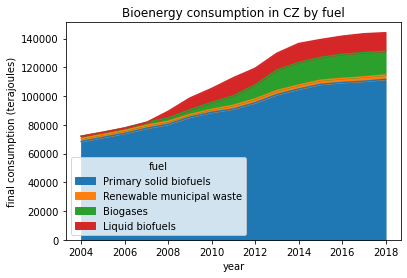

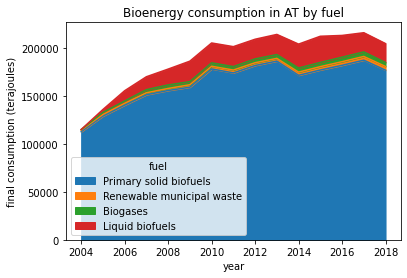

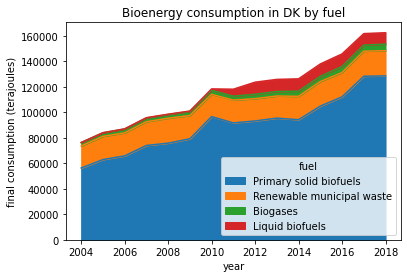

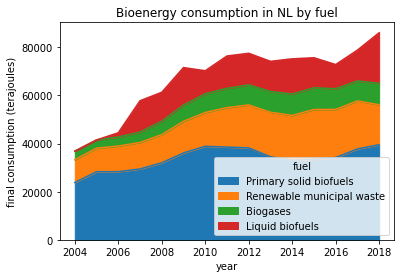

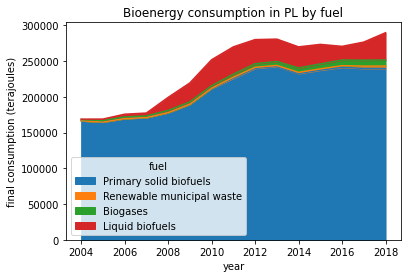

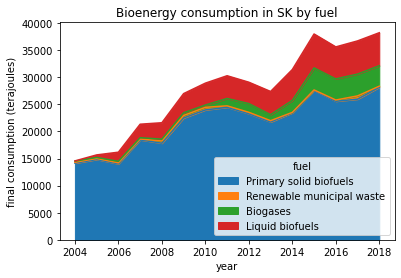

In [23]:
# Pivot tables with consumption for fuel and year in selected countries
for country in ['CZ', 'AT', 'DK', 'NL', 'PL', 'SK']:
    bio = df['siec'].str.fullmatch('|'.join(bio_codes))
    geo = df['geo'] == country
    geodf = df.loc[bio & geo, ['geo', 'year', 'siec', 'fuel', 'unit', 'all_sectors_consumption']]
    geodf = geodf.pivot_table(values='all_sectors_consumption', index='year', columns='fuel')
    geodf = geodf.reindex(columns=['Primary solid biofuels', 'Renewable municipal waste', 'Biogases', 'Liquid biofuels'])
    geodf.plot.area(title=f'Bioenergy consumption in {country} by fuel', ylabel='final consumption (terajoules)')
